# Hyperparameter Tuning Methods Comparision: Example

Cross validation approach based on the following [repo](https://github.com/roamanalytics/roamresearch/tree/master/BlogPosts/Hyperparameter_tuning_comparison)


In [1]:
%matplotlib inline

In [23]:
%load_ext autoreload
%autoreload 1
%aimport hpt_cmp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import dataset_loader as ds
import model_loader as mdl
import seaborn as sns

from hpt_cmp import *

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process, neural_network
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score ,make_scorer
from tqdm import tqdm_notebook, tnrange
from skopt.space import Real, Integer, Categorical

In [4]:
# basic sklearn classification DS
dsBunch = ds.load('digits')
data = (dsBunch.data, dsBunch.target)
n_features = dsBunch.data.shape[1]
n_features

64

# MLPClassifier

Parameters we tune for the MLPClassifier ([full documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)):
> `hidden_layer_sizes`: tuple <br>
> `activation`: {'identity', 'logistic', 'tanh', *'relu'*} <br>
> `solver`: {‘lbfgs’, ‘sgd’, *‘adam’*} <br>
> `alpha`: float, *0.0001* --- regularization term <br>
> `learning_rate`: {*‘constant’*, ‘invscaling’, ‘adaptive’} <br>
> `learning_rate_init`: double, *0.001* <br>
> `random_state` <br>
> `momentum`: float, *0.9* <br>
> `nesterovs_momentum`: bool, *True* <br>
> `early_stopping`: bool, *False* <br>

In [25]:
hls = [(100,)*10, (n_features,)*10, (100,)*5, (n_features,)*5]
alpha = [0.0001, 0.001, 0.01, 0.1, 1]
rs = [0]

# sklean paramgrid
pg = {
    'hidden_layer_sizes': hls,
    'alpha': alpha,
    'random_state': rs
}

# hyperopt paramgird
hg={
    'hidden_layer_sizes': hp.choice('hidden_layer_sizes',hls),
    'alpha': hp.choice('alpha', alpha),
    'random_state': hp.choice('random_state', rs)
}

# skopt paramgrid 
bg = {
    'hidden_layer_sizes': Categorical(hls),
    'alpha': Real(0.001, 1.0, 'loguniform'),
    'random_state': rs
}

# base model parameters
base = {'hidden_layer_sizes':(100,), 'random_state':0}

In [26]:
# define MLPClassifier
hpt_objs = [
        HPT_OBJ('Baseline', base, run_baseline, {}),
        HPT_OBJ('Grid Search', pg, grid_search, {}),
        HPT_OBJ('Random Search', pg, random_search, {'n_iter': MAX_ITER}),
        HPT_OBJ('Bayes Seach', bg, baysian_search, {'n_iter':MAX_ITER}),
        HPT_OBJ('Tree of Parzen Est.', hg, tpe_search, {})
]

mlpc ={
    'model': neural_network.MLPClassifier,
    'hpt_objs': hpt_objs,
    'loss': 'neg_log_loss',
    'metric': accuracy_score,
}

In [27]:
# run tuning with all the specified algorithms 
res = cmp_hpt_methods(data, **mlpc)

10 5


64
{'hidden_layer_sizes': (100,), 'random_state': 0}
-0.10342033921362101
-0.10342033921362101
64
{'alpha': 0.001, 'hidden_layer_sizes': (64, 64, 64, 64, 64), 'random_state': 0}
-0.1461845800266814
-0.1461845800266814
64
{'alpha': 1, 'hidden_layer_sizes': (100, 100, 100, 100, 100), 'random_state': 0}
-0.256846529069653
-0.256846529069653
64
{'alpha': 0.1, 'hidden_layer_sizes': (64, 64, 64, 64, 64, 64, 64, 64, 64, 64), 'random_state': 0}
-0.18908793794441622
-0.18908793794441622
64
{'alpha': 0.01, 'hidden_layer_sizes': (100, 100, 100, 100, 100), 'random_state': 0}
-0.08814028198556574
-0.08814028198556574
64
{'alpha': 0.0001, 'hidden_layer_sizes': (64, 64, 64, 64, 64, 64, 64, 64, 64, 64), 'random_state': 0}
-0.16365976556769493
-0.16365976556769493
64
{'alpha': 0.1, 'hidden_layer_sizes': (100, 100, 100, 100, 100, 100, 100, 100, 100, 100), 'random_state': 0}
-0.1529520485923856
-0.1529520485923856
64
{'alpha': 0.001, 'hidden_layer_sizes': (100, 100, 100, 100, 100, 100, 100, 100, 100, 100

In [31]:
sum_res = []
for r in res:
    t = np.array(r[INNER_RES]['mean_fit_time']).mean()
    sum_res.append((r[HPT_METHOD], t, r[PARAMS_SAMPLED], r[TEST_ACC], r[BEST_PARAMS]))
                   
df = pd.DataFrame(sum_res, columns=[HPT_METHOD, 'TIME', PARAMS_SAMPLED, TEST_ACC, BEST_PARAMS])

In [32]:
df

,HPT method,TIME,Parameters sampled,Test accuracy,Best Parameters
0,Baseline,1.428988,11,0.962963,"{'hidden_layer_sizes': (100,), 'random_state': 0}"
1,Grid Search,2.667392,23,0.974074,"{'alpha': 0.1, 'hidden_layer_sizes': (100, 100..."
2,Random Search,2.482367,23,0.972222,"{'random_state': 0, 'hidden_layer_sizes': (100..."
3,Bayes Seach,4.665588,16,0.975926,"{'alpha': 0.03237092834973749, 'hidden_layer_s..."
4,Tree of Parzen Est.,2.919112,12,0.972222,"{'alpha': 0.01, 'hidden_layer_sizes': (100, 10..."


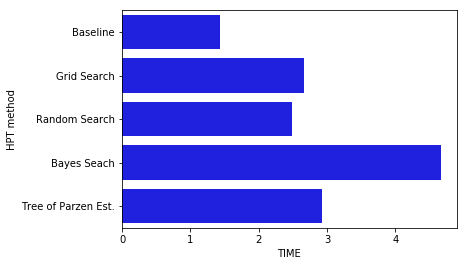

<Figure size 432x288 with 0 Axes>

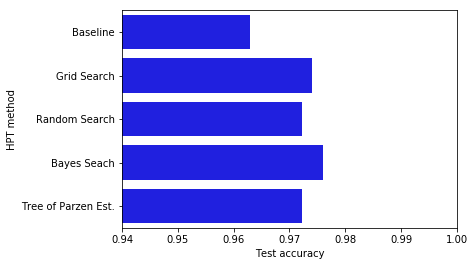

In [33]:
# plot comparison
plt.figure()
sns.barplot(x='TIME', y=HPT_METHOD,data =df, color='b')
plt.figure()
# plot accuracy comparison
fig, ax =plt.subplots()
ax.set(xlim=(0.94, 1.0))
sns.barplot(x=TEST_ACC, y=HPT_METHOD, ax = ax,data =df, color='b')

In [34]:
pd.DataFrame(df[BEST_PARAMS].tolist())

,alpha,hidden_layer_sizes,random_state
0,NaN,"(100,)",0
1,0.100000,"(100, 100, 100, 100, 100)",0
2,0.000100,"(100, 100, 100, 100, 100)",0
3,0.032371,"(100, 100, 100, 100, 100)",0
4,0.010000,"(100, 100, 100, 100, 100)",0
